In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import json
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
from sklearn.exceptions import InconsistentVersionWarning
from sklearn.model_selection import train_test_split
from scr.models.train_neural.utils import load_model, text_to_indices

In [2]:
BASE_DIR = Path.cwd().parent
BASELINE_DIR = BASE_DIR / "models" / "baseline_models"
NEURAL_DIR = BASE_DIR / "models" / "neural_models"
DATA_PATH = BASE_DIR / "data" / "processed" / "labeled_news.csv"
LABEL_MAP_PATH = BASE_DIR / "data" / "processed" / "label_map.json"
TRAIN_NEURAL_PATH = BASE_DIR / "scr" / "models" / "train_neural"

In [3]:
# Поиск результатов для классических моделей
result_files = list(BASELINE_DIR.glob("results_*.json"))
print(f"Найдено файлов с результатами (baseline): {len(result_files)}")

results = {}
for f in result_files:
    model_name = f.stem.replace("results_", "")
    with open(f, "r") as fp:
        results[model_name] = json.load(fp)

# Поиск результатов для нейросетевых моделей
neural_model_dirs = [d for d in NEURAL_DIR.iterdir() if d.is_dir()]
print(f"Найдено папок с нейросетевыми моделями: {len(neural_model_dirs)}")

for model_dir in neural_model_dirs:
    model_name = model_dir.name
    metrics_file = model_dir / "metrics.json"

    if metrics_file.exists():
        with open(metrics_file, "r") as fp:
            results[model_name] = json.load(fp)
        print(f"  ✓ Загружены метрики для {model_name}")
    else:
        print(f"  ✗ metrics.json не найден в {model_dir}")

print(f"Всего моделей: {len(results)}")
print("Доступные модели:", list(results.keys()))

Найдено файлов с результатами (baseline): 3
Найдено папок с нейросетевыми моделями: 1
  ✓ Загружены метрики для fnn
Всего моделей: 4
Доступные модели: ['lgbm', 'lr', 'svm', 'fnn']


In [4]:
df_metrics = pd.DataFrame(results).T
df_metrics = df_metrics.round(4)
print("Сводная таблица метрик:")
display(df_metrics)

Сводная таблица метрик:


,accuracy,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1
lgbm,0.8259,0.8426,0.8069,0.8229,0.8267,0.8259,0.8253
lr,0.8978,0.8808,0.8692,0.8748,0.8977,0.8978,0.8977
svm,0.9012,0.8850,0.8727,0.8786,0.9011,0.9012,0.9010
fnn,0.9022,0.8772,0.8824,0.8796,0.9029,0.9022,0.9024


<Figure size 1200x600 with 0 Axes>

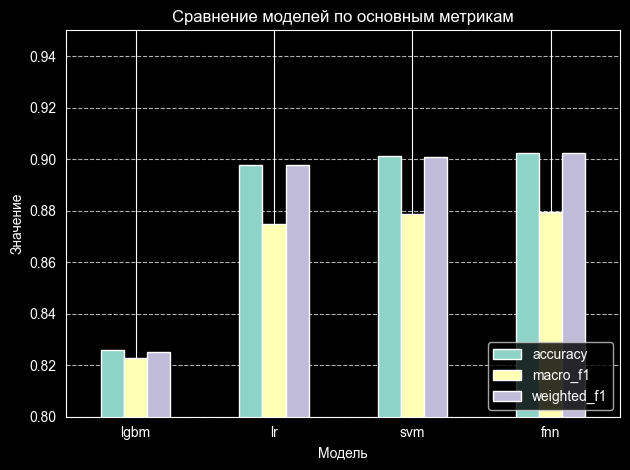

In [5]:
plt.figure(figsize=(12, 6))
metrics_to_plot = ['accuracy', 'macro_f1', 'weighted_f1']
df_metrics[metrics_to_plot].plot(kind='bar', rot=0)
plt.title("Сравнение моделей по основным метрикам")
plt.ylabel("Значение")
plt.xlabel("Модель")
plt.ylim(0.8, 0.95)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [6]:
best_model_name = df_metrics['macro_f1'].idxmax()
best_macro_f1 = df_metrics.loc[best_model_name, 'macro_f1']
print(f"Лучшая модель: {best_model_name} (macro_f1 = {best_macro_f1:.4f})")

Лучшая модель: fnn (macro_f1 = 0.8796)


In [7]:
# Загрузка тестовых данных и лучшей модели для детального анализа
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

df = pd.read_csv(DATA_PATH)
X = df['lemmatized_text'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
)

# Определяем тип лучшей модели
if best_model_name in results and 'vectorizer' in results[best_model_name]:
    # Классическая модель с tf-idf
    tfidf = joblib.load(BASELINE_DIR / "tfidf_vectorizer.pkl")
    X_test_vec = tfidf.transform(X_test)
    best_model = joblib.load(BASELINE_DIR / f"model_{best_model_name}.pkl")
    y_pred = best_model.predict(X_test_vec)

else:
    # Нейросетевая модель
    # 1. Загружаем словарь (нужен для преобразования текста в индексы)
    with open(NEURAL_DIR / best_model_name / "vocab.json", 'r', encoding='utf-8') as f:
        word2idx = json.load(f)

    # 2. Загружаем метрики (если нужны для сравнения)
    with open(NEURAL_DIR / best_model_name / "metrics.json", 'r') as f:
        metrics = json.load(f)

    # 3. Загружаем модель (автоматически воссоздаёт архитектуру и веса)
    if str(TRAIN_NEURAL_PATH) not in sys.path:
        sys.path.append(str(TRAIN_NEURAL_PATH))
    model = load_model(NEURAL_DIR / best_model_name, device='cpu')

    # 4. Подготавливаем тестовые данные
    max_len = 200   # должно совпадать со значением, использованным при обучении
    X_test_indices = [text_to_indices(text, word2idx, max_len) for text in X_test]
    X_test_tensor = torch.tensor(X_test_indices, dtype=torch.long)

    # 5. Получаем предсказания
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, y_pred = torch.max(outputs, 1)
    y_pred = y_pred.numpy()

2026-02-20 17:38:48 | INFO     | scr.models.train_neural.utils | Модель загружена из C:\Users\User\Desktop\ML\News_Classifier\models\neural_models\fnn


In [9]:
target_names = df['category_clean'].unique()
print("Classification report для лучшей модели:")
print(classification_report(y_test, y_pred, zero_division=0))

Classification report для лучшей модели:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     43527
           1       0.87      0.90      0.89      5244
           2       0.91      0.93      0.92      7661
           3       0.86      0.89      0.88     15250
           4       0.97      0.98      0.98      5099
           5       0.85      0.85      0.85      8725
           6       0.82      0.85      0.84      1877
           7       0.89      0.86      0.88      9476
           8       0.85      0.87      0.86      4470
           9       0.80      0.81      0.80      5433
          10       0.88      0.83      0.86       651

    accuracy                           0.90    107413
   macro avg       0.88      0.88      0.88    107413
weighted avg       0.90      0.90      0.90    107413



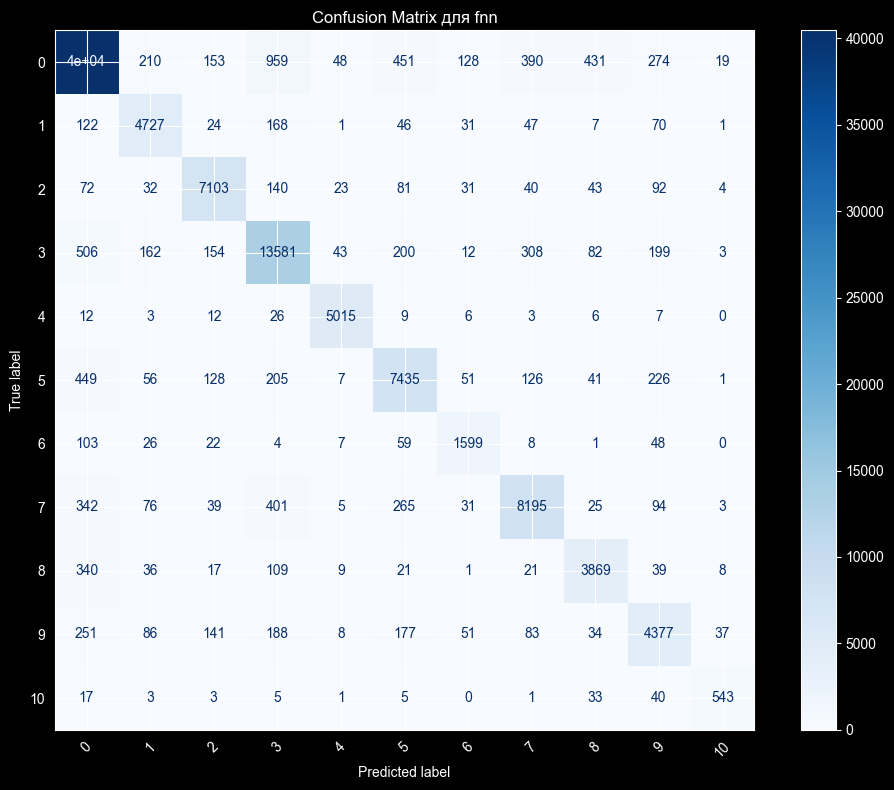

In [10]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title(f"Confusion Matrix для {best_model_name}")
plt.tight_layout()
plt.show()

In [1]:
# Словарь с названиями классов
if best_model_name in results and 'vectorizer' in results[best_model_name]:
    with open(LABEL_MAP_PATH, 'r', encoding='utf-8') as f:
        label_map = json.load(f)
    class_names = {int(k): v for k, v in label_map.items()}

    # Получаем названия признаков (слова) из векторайзера
    feature_names = tfidf.get_feature_names_out()

    coef = best_model.coef_
    classes = best_model.classes_

    print("ТОП-5 СЛОВА ДЛЯ КАЖДОГО КЛАССА:\n")

    for i, class_label in enumerate(classes):
        top_indices = coef[i].argsort()[-5:][::-1]
        top_words = feature_names[top_indices]
        top_scores = coef[i][top_indices]

        print(f"Класс: {class_names[class_label]}")
        for word, score in zip(top_words, top_scores):
            print(f"  {word}: {score:.4f}")
        print()
else:
    print("⚠Для нейросетевых моделей анализ топ-слов не поддерживается")

NameError: name 'best_model_name' is not defined